In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from random import choice
from random import seed
from random import randrange
import collections
import statistics
import math
import numpy as numpy
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

In [2]:
#Defining a function to delete variables with MAF = 0
def Remove_Empty_Variables (original_feature_matrix, label_name, duration_name):
    #Removing the label column to create a list of features
    feature_df = original_feature_matrix.copy()
    feature_df= feature_df.drop(columns = [label_name, duration_name])
    
    #Creating a list of features 
    feature_list = []
    for column in feature_df:
        feature_list.append(str(column))

    feature_matrix_no_empty_variables = pd.DataFrame()
    
    #Creating a list of features with MAF = 0 to delete
    MAF_0_features = []
    
    for i in range (0, len(feature_list)):
        #If the MAF of the feature is less than the cutoff, it will be removed
        if feature_df[feature_list[i]].sum()/(2*len(feature_df.index)) == 0:
            MAF_0_features.append(feature_list[i])
    
    #Removing the features
    for j in range (0, len(MAF_0_features)):
        feature_list.remove(MAF_0_features[j])
    
    #Updating the feature matrix accordingly
    for k in range (0, len(feature_list)):
        feature_matrix_no_empty_variables[feature_list[k]] = feature_df[feature_list[k]]
    
    #Adding the class label to the feature matrix
    feature_matrix_no_empty_variables[label_name] = original_feature_matrix[label_name]
    feature_matrix_no_empty_variables[duration_name] = original_feature_matrix[duration_name]
    
    #Saving the feature list of nonempty features
    nonempty_feature_list = feature_list
    
    return feature_matrix_no_empty_variables, MAF_0_features, nonempty_feature_list


In [3]:
#Defining a function to group features randomly, each feature can be in a number of groups up to a set max

def Random_Feature_Grouping(feature_matrix, label_name, duration_name, number_of_groups, min_features_per_group, 
                            max_number_of_groups_with_feature):
    
    #Removing the label column to create a list of features
    feature_df = feature_matrix.drop(columns = [label_name, duration_name])
    
    #Creating a list of features 
    feature_list = []
    for column in feature_df:
        feature_list.append(str(column))
    
    #Adding a random number of repeats of the features so that features can be in more than one group
    for w in range (0, len(feature_list)):
        repeats = randrange(max_number_of_groups_with_feature)
        for i in range (0, repeats):
            feature_list.append(feature_list[w])
    
    #Shuffling the feature list to enable random groups
    random.shuffle(feature_list)
    
    #Creating a dictionary of the groups
    feature_groups = {}
    
    #Assigns the minimum number of features to all the groups
    for x in range (0, min_features_per_group*number_of_groups, min_features_per_group):
        feature_groups[x/min_features_per_group] = feature_list[x:x+min_features_per_group]
    
    #Randomly distributes the remaining features across the set number of groups
    for y in range (min_features_per_group*number_of_groups, len(feature_list)):
        feature_groups[random.choice(list(feature_groups.keys()))].append(feature_list[y])
    
    #Removing duplicates of features in the same bin
    for z in range (0, len(feature_groups)):
        unique = []
        for a in range (0, len(feature_groups[z])):
            if feature_groups[z][a] not in unique:
                unique.append(feature_groups[z][a])
        feature_groups[z] = unique
    
    #Creating a dictionary with bin labels
    binned_feature_groups = {}
    for index in range (0, len(feature_groups)):
        binned_feature_groups["Bin " + str(index + 1)] = feature_groups[index]
    
    return feature_list, binned_feature_groups


In [4]:
#Defining a function to create a feature matrix where each feature is a bin of features from the original feature matrix

def Grouped_Feature_Matrix(feature_matrix, label_name, duration_name, binned_feature_groups):
    
    #Creating an empty data frame for the feature matrix with bins
    bins_df = pd.DataFrame()
    
    #Creating a list of 0s, where the number of 0s is the number of instances in the original feature matrix
    zero_list = []
    for a in range (0, len(feature_matrix.index)):
        zero_list.append(0)
        
    #Creating a dummy data frame
    dummy_df = pd.DataFrame()
    dummy_df['Zeros'] = zero_list
    #The list and dummy data frame will be used for adding later
    
   #For each feature group/bin, the values of the amino acid in the bin will be summed to create a value for the bin 
    count = 0
    for key in binned_feature_groups:
        sum_column = dummy_df['Zeros']
        for j in range (0, len(binned_feature_groups[key])):
            sum_column = sum_column + feature_matrix[binned_feature_groups[key][j]]
        count = count + 1
        bins_df[key] = sum_column
    
    #Adding the class label to the data frame
    bins_df[label_name] = feature_matrix[label_name]
    bins_df[duration_name] = feature_matrix[duration_name]
    return bins_df

In [5]:
def Cox_Feature_Importance(bin_feature_matrix, covariate_matrix, amino_acid_bins, label_name, duration_name):
    
    bin_scores = {}
    for Bin_name in amino_acid_bins.keys():
        column_values = bin_feature_matrix[Bin_name].to_list()
        for r in range(0, len(column_values)):
            if column_values[r] > 0:
                column_values[r] = 1
        data = covariate_matrix.copy()
        data['Bin'] = column_values
        data = data.loc[:, (data != data.iloc[0]).any()] 
        cph = CoxPHFitter()
        cph.fit(data,duration_name,event_col=label_name)
        bin_scores[Bin_name] = 0 - cph.AIC_partial_
        del data['Bin']
        
    
    return bin_scores

In [6]:
#Defining a function to probabilitically select 2 parent bins based on their feature importance rank
#Tournament Selection works in this case by choosing a random sample of the bins and choosing the best two scores
def Tournament_Selection_Parent_Bins(bin_scores):
    
    #Choosing a random sample of 5% of the bin population or if that would be too small, choosing a sample of 50%
    if round(0.05*len(bin_scores)) < 2:
        samplekeys = random.sample(bin_scores.keys(), round(0.5*len(bin_scores)))
    else: 
        samplekeys = random.sample(bin_scores.keys(), round(0.05*len(bin_scores)))
    
    sample = {}
    for key in samplekeys:
        sample[key] = bin_scores[key]
    
    #Sorting the bins from best score to worst score
    sorted_bin_scores = dict(sorted(sample.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    
    #Choosing the parent bins and adding them to a list of parent bins
    parent_bins = [sorted_bin_list[0], sorted_bin_list[1]]
    
    return parent_bins


# In[23]:


#Defining a function for crossover and mutation that creates n offspring based on crossover of selected parents
#n is the max number of bins (but not all the offspring will carry on, as the worst will be deleted in Step 2a next time)
def Crossover_and_Mutation(max_population_of_bins, elitism_parameter, feature_list, binned_feature_groups, bin_scores, 
                           crossover_probability, mutation_probability):

    #Creating a list for offspring
    offspring_list = []
    
    #Creating a number of offspring equal to the the number needed to replace the nonelites
    #Each pair of parents will produce two offspring
    for i in range (0, int((max_population_of_bins - (elitism_parameter*max_population_of_bins))/2)):
        #Choosing the two parents and gettings the list of features in each parent bin
        parent_bins = Tournament_Selection_Parent_Bins(bin_scores)
        parent1_features = binned_feature_groups[parent_bins[0]].copy()
        parent2_features = binned_feature_groups[parent_bins[1]].copy()

        #Creating two lists for the offspring bins
        offspring1 = []
        offspring2 = []
        
        #CROSSOVER
        #Each feature in the parent bin will crossover based on the given probability (uniform crossover)
        for j in range (0, len(parent1_features)):
            if crossover_probability > random.random():
                offspring2.append(parent1_features[j])
            else:
                offspring1.append(parent1_features[j])
        
        for k in range (0, len(parent2_features)):
            if crossover_probability > random.random():
                offspring1.append(parent2_features[k])
            else:
                offspring2.append(parent2_features[k])
        
        #Ensuring that each of the offspring is no more than twice the size of the other offspring
        while len(offspring1) > len(offspring2):
            switch = random.choice(offspring1)
            offspring1.remove(switch)
            offspring2.append(switch)
            
        while len(offspring2) > len(offspring1):
            switch = random.choice(offspring2)
            offspring2.remove(switch)
            offspring1.append(switch)
        
        
        #MUTATION
        #Mutation only occurs with a certain probability on each feature in the original feature space
        
        #Applying the mutation operation to the first offspring
        #Creating a probability for adding a feature that accounts for the ratio between the feature list and the size of the bin
        if len(offspring1) > 0 and len(offspring1) != len(feature_list):            
            mutation_addition_prob = (mutation_probability)*(len(offspring1))/((len(feature_list)-len(offspring1)))
        elif len(offspring1) == 0 and len(offspring1) != len(feature_list):
            mutation_addition_prob = mutation_probability
        elif len(offspring1) == len(feature_list):
            mutation_addition_prob = 0
        
        deleted_list = []
        #Deletion form of mutation
        for l in range (0, len(offspring1)):
            #Mutation (deletion) occurs on this feature with probability equal to the mutation parameter
            if mutation_probability > random.random():
                deleted_list.append(offspring1[l])
                
        
        for l in range (0, len(deleted_list)):
            offspring1.remove(deleted_list[l])
            
        #Creating a list of features outside the offspring
        features_not_in_offspring = [item for item in feature_list if item not in offspring1]
        
        #Addition form of mutation
        for l in range (0, len(features_not_in_offspring)):
            #Mutation (addiiton) occurs on this feature with probability proportional to the mutation parameter
            #The probability accounts for the ratio between the feature list and the size of the bin
            if mutation_addition_prob > random.random():
                    offspring1.append(features_not_in_offspring[l])
        
        #Applying the mutation operation to the second offspring
        #Creating a probability for adding a feature that accounts for the ratio between the feature list and the size of the bin
        if len(offspring2) > 0 and len(offspring2) != len(feature_list):            
            mutation_addition_prob = (mutation_probability)*(len(offspring2))/((len(feature_list)-len(offspring2)))
        elif len(offspring2) == 0 and len(offspring2) != len(feature_list):
            mutation_addition_prob = mutation_probability
        elif len(offspring2) == len(feature_list):
            mutation_addition_prob = 0
        
        deleted_list = []
        #Deletion form of mutation
        for l in range (0, len(offspring2)):
            #Mutation (deletion) occurs on this feature with probability equal to the mutation parameter
            if mutation_probability > random.random():
                deleted_list.append(offspring2[l])
        
        for l in range (0, len(deleted_list)):
            offspring2.remove(deleted_list[l])
        
        #Creating a list of features outside the offspring
        features_not_in_offspring = [item for item in feature_list if item not in offspring2]
        
        #Addition form of mutation
        for l in range (0, len(features_not_in_offspring)):
            #Mutation (addiiton) occurs on this feature with probability proportional to the mutation parameter
            #The probability accounts for the ratio between the feature list and the size of the bin
            if mutation_addition_prob > random.random():
                    offspring2.append(features_not_in_offspring[l])
            
        #CLEANUP
        #Deleting any repeats of an amino acid in a bin
        #Removing duplicates of features in the same bin that may arise due to crossover
        unique = []
        for a in range (0, len(offspring1)):
            if offspring1[a] not in unique:
                unique.append(offspring1[a])
        
        #Adding random features from outside the bin to replace the deleted features in the bin
        replace_number = len(offspring1) - len(unique)
        features_not_in_offspring = []
        features_not_in_offspring = [item for item in feature_list if item not in offspring1]
        offspring1 = unique.copy()
        if len(features_not_in_offspring) > replace_number:
            replacements = random.sample(features_not_in_offspring, replace_number)
        else:
            replacements = features_not_in_offspring.copy()
        offspring1.extend(replacements)
        
        unique = []
        for a in range (0, len(offspring2)):
            if offspring2[a] not in unique:
                unique.append(offspring2[a])
        
        #Adding random features from outside the bin to replace the deleted features in the bin
        replace_number = len(offspring2) - len(unique)
        features_not_in_offspring = []
        features_not_in_offspring = [item for item in feature_list if item not in offspring2]
        offspring2 = unique.copy()
        if len(features_not_in_offspring) > replace_number:
            replacements = random.sample(features_not_in_offspring, replace_number)
        else:
            replacements = features_not_in_offspring.copy()
        offspring2.extend(replacements)
        
        #Adding the new offspring to the list of feature bins
        offspring_list.append(offspring1)
        offspring_list.append(offspring2)
        
   
    return offspring_list


# In[24]:


def Create_Next_Generation(binned_feature_groups, bin_scores, max_population_of_bins, elitism_parameter, offspring_list):
    
    #Sorting the bins from best score to worst score
    sorted_bin_scores = dict(sorted(bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
        
    #Determining the number of elite bins
    number_of_elite_bins = round(max_population_of_bins*elitism_parameter)
    elites = []
    #Adding the elites to a list of elite feature bins
    for a in range (0, number_of_elite_bins):
        elites.append(binned_feature_groups[sorted_bin_list[a]])
    
    #Creating a list of feature bins (without labels because those will be changed as things get deleted and added)
    feature_bin_list = elites.copy()
    
    #Adding the offspring to the feature bin list
    feature_bin_list.extend(offspring_list)
    return feature_bin_list


# In[25]:


In [7]:
#Defining a function to recreate the feature matrix (add up values of amino a cids from original dataset)
def Regroup_Feature_Matrix(feature_list, feature_matrix, label_name, duration_name, feature_bin_list):
    
    
    #First deleting any bins that are empty
    #Creating a list of bins to delete
    bins_to_delete = []
    for i in feature_bin_list:
        if not i:
            bins_to_delete.append(i)
    for i in bins_to_delete:
        feature_bin_list.remove(i)
    
    #The length of the bin will be equal to the average length of nonempty bins in the population
    bin_lengths = []
    for i in feature_bin_list:
        if len(i) > 0:
            bin_lengths.append(len(i))      
    replacement_length = round(statistics.mean(bin_lengths))
    
    #Replacing each deleted bin with a bin with random features
    for i in range (0, len(bins_to_delete)):
        replacement = random.sample(feature_list, replacement_length)
        feature_bin_list.append(replacement)

    #Checking each pair of bins, if the bins are duplicates then one of the copies will be deleted
    seen = set()
    unique = []
    for x in feature_bin_list:
        srtd = tuple(sorted(x))
        if srtd not in seen:
            unique.append(x)
            seen.add(srtd)
    
    #Replacing each deleted bin with a bin with random features
    replacement_number = len(feature_bin_list) - len(unique)
    feature_bin_list = unique.copy()
    
    for i in feature_bin_list:
        if len(i) > 0:
            bin_lengths.append(len(i))      
    replacement_length = round(statistics.mean(bin_lengths))
    
    for i in range(0, replacement_number):
        replacement = random.sample(feature_list, replacement_length)
        feature_bin_list.append(replacement)
    
    
    #Deleting duplicate features in the same bin and replacing them with random features
    for Bin in range (0, len(feature_bin_list)):
        unique = []
        for a in range (0, len(feature_bin_list[Bin])):
            if feature_bin_list[Bin][a] not in unique:
                unique.append(feature_bin_list[Bin][a])
    
        replace_number = len(feature_bin_list[Bin]) - len(unique)
        
        features_not_in_offspring = []
        features_not_in_offspring = [item for item in feature_list if item not in feature_bin_list[Bin]]
        
        bin_replacement = unique.copy()
        if len(features_not_in_offspring) > replace_number:
            replacements = random.sample(features_not_in_offspring, replace_number)
        else:
            replacements = features_not_in_offspring.copy()
        bin_replacement.extend(replacements)
        
        feature_bin_list[Bin] = bin_replacement.copy()

    
    #Creating an empty data frame for the feature matrix with bins
    bins_df = pd.DataFrame()
    
    #Creating a list of 0s, where the number of 0s is the number of instances in the original feature matrix
    zero_list = []
    for a in range (0, len(feature_matrix.index)):
        zero_list.append(0)
        
    #Creating a dummy data frame
    dummy_df = pd.DataFrame()
    dummy_df['Zeros'] = zero_list
    #The list and dummy data frame will be used for adding later
    
   #For each feature group/bin, the values of the amino acid in the bin will be summed to create a value for the bin
   #This will be used to create a a feature matrix for the bins and a dictionary of binned feature groups

    count = 0
    binned_feature_groups = {}
    
    for i in range (0, len(feature_bin_list)):
        sum_column = dummy_df['Zeros']
        for j in range (0, len(feature_bin_list[i])):
            sum_column = sum_column + feature_matrix[feature_bin_list[i][j]]
        count = count + 1
        bins_df["Bin " + str(count)] = sum_column
        binned_feature_groups["Bin " + str(count)] = feature_bin_list[i]
    
    #Adding the class label to the data frame
    bins_df[label_name] = feature_matrix[label_name]
    bins_df[duration_name] = feature_matrix[duration_name]
    return bins_df, binned_feature_groups

In [8]:
def CoxRARE (given_starting_point, amino_acid_start_point, amino_acid_bins_start_point, iterations, original_feature_matrix, 
          label_name, duration_name, covariates, set_number_of_bins, min_features_per_group, max_number_of_groups_with_feature,
          crossover_probability, mutation_probability, elitism_parameter):
    
    #Separating features we want to bin from covariates
    feature_matrix = original_feature_matrix.drop(covariates, axis = 1)
    covariate_matrix = original_feature_matrix[covariates]
    covariate_matrix[label_name] = original_feature_matrix[label_name]
    covariate_matrix[duration_name] = original_feature_matrix[duration_name]
    
    #identify all categorical variables
    cat_columns = covariate_matrix.select_dtypes(['object']).columns

    #convert all categorical variables to numeric
    covariate_matrix[cat_columns] = covariate_matrix[cat_columns].apply(lambda x: pd.factorize(x)[0])
    covariate_matrix = covariate_matrix.dropna(axis='columns')
    covariate_matrix= covariate_matrix.loc[:, (covariate_matrix!= covariate_matrix.iloc[0]).any()] 
    
    #Step 0: Deleting Empty Features (MAF = 0)
    feature_matrix_no_empty_variables, MAF_0_features, nonempty_feature_list = Remove_Empty_Variables(feature_matrix, 
                                                                                                      label_name, duration_name)

    #Step 1: Initialize Population of Candidate Bins 
    #Initialize Feature Groups
    
    #If there is a starting point, use that for the amino acid list and the amino acid bins list
    if given_starting_point == True:
        amino_acid_bins = amino_acid_bins_start_point.copy()
        amino_acids = amino_acid_start_point.copy()
        
        features_to_remove = [item for item in amino_acids if item not in nonempty_feature_list]
        for feature in features_to_remove:
            amino_acids.remove(feature)
                
        bin_names = amino_acid_bins.keys()
        for bin_name in bin_names:
            for feature in features_to_remove:
                if feature in amino_acid_bins[bin_name]:
                    amino_acid_bins[bin_name].remove(feature)
                    
    #Otherwise randomly initialize the bins
    elif given_starting_point == False:
        amino_acids, amino_acid_bins = Random_Feature_Grouping(feature_matrix_no_empty_variables, label_name, duration_name,
                                                               set_number_of_bins, min_features_per_group, 
                                                               max_number_of_groups_with_feature)
    
    
    #Create Initial Binned Feature Matrix
    bin_feature_matrix = Grouped_Feature_Matrix(feature_matrix_no_empty_variables, label_name, duration_name, amino_acid_bins)
    
    #Step 2: Genetic Algorithm with Feature Scoring (repeated for a given number of iterations)
    for i in range (0, iterations):
        
        #Step 2a: Feature Importance Scoring and Bin Deletion
        
        amino_acid_bin_scores = Cox_Feature_Importance(bin_feature_matrix, covariate_matrix, amino_acid_bins, label_name, duration_name)
            
         #Step 2b: Genetic Algorithm 
        #Creating the offspring bins through crossover and mutation
        offspring_bins = Crossover_and_Mutation(set_number_of_bins, elitism_parameter, amino_acids, amino_acid_bins, amino_acid_bin_scores,
                                                crossover_probability, mutation_probability)
        
        #Creating the new generation by preserving some elites and adding the offspring
        feature_bin_list = Create_Next_Generation(amino_acid_bins, amino_acid_bin_scores, set_number_of_bins, 
                                                  elitism_parameter, offspring_bins)
        
        bin_feature_matrix, amino_acid_bins = Regroup_Feature_Matrix(amino_acids, feature_matrix, label_name, duration_name, feature_bin_list)
    
    #Creating the final amino acid bin scores
    amino_acid_bin_scores = Cox_Feature_Importance(bin_feature_matrix, covariate_matrix, amino_acid_bins, label_name, duration_name)

    
    return bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, MAF_0_features


In [14]:
cox_test_data = pd.read_csv('$Imp1.csv')
AAs = ['A1', 'A10', 'A100', 'A101', 'A102', 'A103', 'A104', 'A105', 'A106', 'A107', 'A108', 'A109', 'A11', 'A110', 'A111', 'A112', 'A113', 'A114', 'A115', 'A116', 'A117', 'A118', 'A119', 'A12', 'A120', 'A121', 'A122', 'A123', 'A124', 'A125', 'A126', 'A127', 'A128', 'A129', 'A13', 'A130', 'A131', 'A132', 'A133', 'A134', 'A135', 'A136', 'A137', 'A138', 'A139', 'A14', 'A140', 'A141', 'A142', 'A143', 'A144', 'A145', 'A146', 'A147', 'A148', 'A149', 'A15', 'A150', 'A151', 'A152', 'A153', 'A154', 'A155', 'A156', 'A157', 'A158', 'A159', 'A16', 'A160', 'A161', 'A162', 'A163', 'A164', 'A165', 'A166', 'A167', 'A168', 'A169', 'A17', 'A170', 'A171', 'A172', 'A173', 'A174', 'A175', 'A176', 'A177', 'A178', 'A179', 'A18', 'A180', 'A181', 'A182', 'A183', 'A184', 'A185', 'A186', 'A187', 'A188', 'A189', 'A19', 'A190', 'A191', 'A192', 'A193', 'A194', 'A195', 'A196', 'A197', 'A198', 'A199', 'A2', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A3', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A4', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A5', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A6', 'A60', 'A61', 'A62', 'A63', 'A64', 'A65', 'A66', 'A67', 'A68', 'A69', 'A7', 'A70', 'A71', 'A72', 'A73', 'A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A8', 'A80', 'A81', 'A82', 'A83', 'A84', 'A85', 'A86', 'A87', 'A88', 'A89', 'A9', 'A90', 'A91', 'A92', 'A93', 'A94', 'A95', 'A96', 'A97', 'A98', 'A99', 'B1', 'B10', 'B100', 'B101', 'B102', 'B103', 'B104', 'B105', 'B106', 'B107', 'B108', 'B109', 'B11', 'B110', 'B111', 'B112', 'B113', 'B114', 'B115', 'B116', 'B117', 'B118', 'B119', 'B12', 'B120', 'B121', 'B122', 'B123', 'B124', 'B125', 'B126', 'B127', 'B128', 'B129', 'B13', 'B130', 'B131', 'B132', 'B133', 'B134', 'B135', 'B136', 'B137', 'B138', 'B139', 'B14', 'B140', 'B141', 'B142', 'B143', 'B144', 'B145', 'B146', 'B147', 'B148', 'B149', 'B15', 'B150', 'B151', 'B152', 'B153', 'B154', 'B155', 'B156', 'B157', 'B158', 'B159', 'B16', 'B160', 'B161', 'B162', 'B163', 'B164', 'B165', 'B166', 'B167', 'B168', 'B169', 'B17', 'B170', 'B171', 'B172', 'B173', 'B174', 'B175', 'B176', 'B177', 'B178', 'B179', 'B18', 'B180', 'B181', 'B182', 'B183', 'B184', 'B185', 'B186', 'B187', 'B188', 'B189', 'B19', 'B190', 'B191', 'B192', 'B193', 'B194', 'B2', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B3', 'B30', 'B31', 'B32', 'B33', 'B34', 'B35', 'B36', 'B37', 'B38', 'B39', 'B4', 'B40', 'B41', 'B42', 'B43', 'B44', 'B45', 'B46', 'B47', 'B48', 'B49', 'B5', 'B50', 'B51', 'B52', 'B53', 'B54', 'B55', 'B56', 'B57', 'B58', 'B59', 'B6', 'B60', 'B61', 'B62', 'B63', 'B64', 'B65', 'B66', 'B67', 'B68', 'B69', 'B7', 'B70', 'B71', 'B72', 'B73', 'B74', 'B75', 'B76', 'B77', 'B78', 'B79', 'B8', 'B80', 'B81', 'B82', 'B83', 'B84', 'B85', 'B86', 'B87', 'B88', 'B89', 'B9', 'B90', 'B91', 'B92', 'B93', 'B94', 'B95', 'B96', 'B97', 'B98', 'B99', 'C1', 'C10', 'C100', 'C101', 'C102', 'C103', 'C104', 'C105', 'C106', 'C107', 'C108', 'C109', 'C11', 'C110', 'C111', 'C112', 'C113', 'C114', 'C115', 'C116', 'C117', 'C118', 'C119', 'C12', 'C120', 'C121', 'C122', 'C123', 'C124', 'C125', 'C126', 'C127', 'C128', 'C129', 'C13', 'C130', 'C131', 'C132', 'C133', 'C134', 'C135', 'C136', 'C137', 'C138', 'C139', 'C14', 'C140', 'C141', 'C142', 'C143', 'C144', 'C145', 'C146', 'C147', 'C148', 'C149', 'C15', 'C150', 'C151', 'C152', 'C153', 'C154', 'C155', 'C156', 'C157', 'C158', 'C159', 'C16', 'C160', 'C161', 'C162', 'C163', 'C164', 'C165', 'C166', 'C167', 'C168', 'C169', 'C17', 'C170', 'C171', 'C172', 'C173', 'C174', 'C175', 'C176', 'C177', 'C178', 'C179', 'C18', 'C180', 'C181', 'C182', 'C183', 'C184', 'C185', 'C186', 'C187', 'C188', 'C189', 'C19', 'C190', 'C191', 'C192', 'C193', 'C194', 'C195', 'C196', 'C197', 'C198', 'C199', 'C2', 'C20', 'C200', 'C201', 'C202', 'C203', 'C204', 'C205', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C3', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C4', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C5', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C6', 'C60', 'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C7', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C8', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C9', 'C90', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99', 'DQB11', 'DQB110', 'DQB111', 'DQB112', 'DQB113', 'DQB114', 'DQB115', 'DQB116', 'DQB117', 'DQB118', 'DQB119', 'DQB12', 'DQB120', 'DQB121', 'DQB122', 'DQB123', 'DQB124', 'DQB125', 'DQB126', 'DQB127', 'DQB128', 'DQB129', 'DQB13', 'DQB130', 'DQB131', 'DQB132', 'DQB133', 'DQB134', 'DQB135', 'DQB136', 'DQB137', 'DQB138', 'DQB139', 'DQB14', 'DQB140', 'DQB141', 'DQB142', 'DQB143', 'DQB144', 'DQB145', 'DQB146', 'DQB147', 'DQB148', 'DQB149', 'DQB15', 'DQB150', 'DQB151', 'DQB152', 'DQB153', 'DQB154', 'DQB155', 'DQB156', 'DQB157', 'DQB158', 'DQB159', 'DQB16', 'DQB160', 'DQB161', 'DQB162', 'DQB163', 'DQB164', 'DQB165', 'DQB166', 'DQB167', 'DQB168', 'DQB169', 'DQB17', 'DQB170', 'DQB171', 'DQB172', 'DQB173', 'DQB174', 'DQB175', 'DQB176', 'DQB177', 'DQB178', 'DQB179', 'DQB18', 'DQB180', 'DQB181', 'DQB182', 'DQB183', 'DQB184', 'DQB185', 'DQB186', 'DQB187', 'DQB188', 'DQB189', 'DQB19', 'DQB190', 'DQB191', 'DQB192', 'DQB193', 'DQB194', 'DRB11', 'DRB110', 'DRB111', 'DRB112', 'DRB113', 'DRB114', 'DRB115', 'DRB116', 'DRB117', 'DRB118', 'DRB119', 'DRB12', 'DRB120', 'DRB121', 'DRB122', 'DRB123', 'DRB124', 'DRB125', 'DRB126', 'DRB127', 'DRB128', 'DRB129', 'DRB13', 'DRB130', 'DRB131', 'DRB132', 'DRB133', 'DRB134', 'DRB135', 'DRB136', 'DRB137', 'DRB138', 'DRB139', 'DRB14', 'DRB140', 'DRB141', 'DRB142', 'DRB143', 'DRB144', 'DRB145', 'DRB146', 'DRB147', 'DRB148', 'DRB149', 'DRB15', 'DRB150', 'DRB151', 'DRB152', 'DRB153', 'DRB154', 'DRB155', 'DRB156', 'DRB157', 'DRB158', 'DRB159', 'DRB16', 'DRB160', 'DRB161', 'DRB162', 'DRB163', 'DRB164', 'DRB165', 'DRB166', 'DRB167', 'DRB168', 'DRB169', 'DRB17', 'DRB170', 'DRB171', 'DRB172', 'DRB173', 'DRB174', 'DRB175', 'DRB176', 'DRB177', 'DRB178', 'DRB179', 'DRB18', 'DRB180', 'DRB181', 'DRB182', 'DRB183', 'DRB184', 'DRB185', 'DRB186', 'DRB187', 'DRB188', 'DRB189', 'DRB19', 'DRB190', 'DRB191', 'DRB192', 'DRB193', 'DRB194']
coxmodeldata = ['DON_AGE', 'REC_AGE_AT_TX', 'yearslice', 'diab_noted', 'DCD', 'ln_don_wgt_kg_0c', 'ln_don_wgt_kg_0c_s55', 'dcadcodanox', 'dcadcodcva', 'dcadcodcnst', 'dcadcodoth', 'don_ecd', 'don_htn_0c', 'mmA0', 'mmA1', 'mmB0', 'mmB1', 'mmDR0', 'mmDR1', 'mm0', 'shared', 'PKPRA_1080', 'PKPRA_GE80', 'PKPRA_MS', 'don_cmv_negative', 'rbmi_miss', 'rbmi_gt_20', 'graftyrs', 'grf_fail', 'can_dgn_htn_ndm', 'can_dgn_pk_ndm', 'can_dgn_gd_ndm', 'rec_age_spline_35', 'rec_age_spline_50', 'rec_age_spline_65', 'rbmi_DM', 'rbmi_gt_20_DM', 'dm_can_age_spline_50', 'ln_c_hd_0c', 'ln_c_hd_m', 'age_diab', 'age_ecd']
feats = AAs + coxmodeldata
data = cox_test_data[feats]

C:\Users\Sphia\AppData\Local\Temp\ipykernel_21272\2368470199.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  cox_test_data = pd.read_csv('$Imp1.csv')


In [10]:
covariates = ['DON_AGE', 'REC_AGE_AT_TX', 'yearslice', 'diab_noted', 'DCD', 'ln_don_wgt_kg_0c', 'ln_don_wgt_kg_0c_s55', 'dcadcodanox', 'dcadcodcva', 'dcadcodcnst', 'dcadcodoth', 'don_ecd', 'don_htn_0c', 'mmA0', 'mmA1', 'mmB0', 'mmB1', 'mmDR0', 'mmDR1', 'mm0', 'shared', 'PKPRA_1080', 'PKPRA_GE80', 'PKPRA_MS', 'don_cmv_negative', 'rbmi_miss', 'rbmi_gt_20', 'can_dgn_htn_ndm', 'can_dgn_pk_ndm', 'can_dgn_gd_ndm', 'rec_age_spline_35', 'rec_age_spline_50', 'rec_age_spline_65', 'rbmi_DM', 'rbmi_gt_20_DM', 'dm_can_age_spline_50', 'ln_c_hd_0c', 'ln_c_hd_m', 'age_diab', 'age_ecd']


In [11]:
bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, MAF_0_features = CoxRARE (False, False, False, 1, data, 
          'grf_fail', 'graftyrs', covariates, 100, 2, 2, 0.8, 0.4, 0.8)

C:\Users\Sphia\AppData\Local\Temp\ipykernel_21272\1044014012.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_matrix_no_empty_variables[feature_list[k]] = feature_df[feature_list[k]]
C:\Users\Sphia\AppData\Local\Temp\ipykernel_21272\1044014012.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_matrix_no_empty_variables[feature_list[k]] = feature_df[feature_list[k]]
C:\Users\Sphia\AppData\Local\Temp\ipykernel_21272\1044014012.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

In [12]:
def Top_Bin_Summary(original_feature_matrix, label_name, duration_name, bin_feature_matrix, bins, bin_scores):
    
    #Ordering the bin scores from best to worst
    sorted_bin_scores = dict(sorted(bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    
    topbin = sorted_bin_list[0]
    
    df_0 = bin_feature_matrix.loc[bin_feature_matrix[topbin] == 0]
    df_1 = bin_feature_matrix.loc[bin_feature_matrix[topbin] > 0]
        
    durations_no = df_0[duration_name].to_list()        
    event_observed_no = df_0[label_name].to_list()

    durations_mm = df_1[duration_name].to_list()
    event_observed_mm = df_1[label_name].to_list()
        
    results = logrank_test(durations_no, durations_mm, event_observed_A=event_observed_no, event_observed_B=event_observed_mm)
    
    print("Bin of Amino Acid Positions:")
    print(bins[topbin])
    print("---")
    print("Number of Instances with No Mismatches in Bin:")
    print(len(event_observed_no))
    print("Number of Instances with Mismatch(es) in Bin:")
    print(len(event_observed_mm))
    print("---")
    print("p-value from Log Rank Test:")
    print(results.p_value)
    results.print_summary()

    kmf1 = KaplanMeierFitter() 

    ## fit the model for 1st cohort
    kmf1.fit(durations_no, event_observed_no, label='No Mismatches in Bin')

    a1 = kmf1.plot()
    a1.set_ylabel('Survival Probability')


    ## fit the model for 2nd cohort
    kmf1.fit(durations_mm, event_observed_mm, label='Mismatch(es) in Bin')
    kmf1.plot(ax=a1)
    a1.set_xlabel('Years After Transplant')


    

Bin of Amino Acid Positions:
['DQB120', 'DRB173', 'C54', 'C139', 'DQB146']
---
Number of Instances with No Mismatches in Bin:
123547
Number of Instances with Mismatch(es) in Bin:
43027
---
p-value from Log Rank Test:
2.0286227230978804e-39


ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         172.57 <0.005    128.53

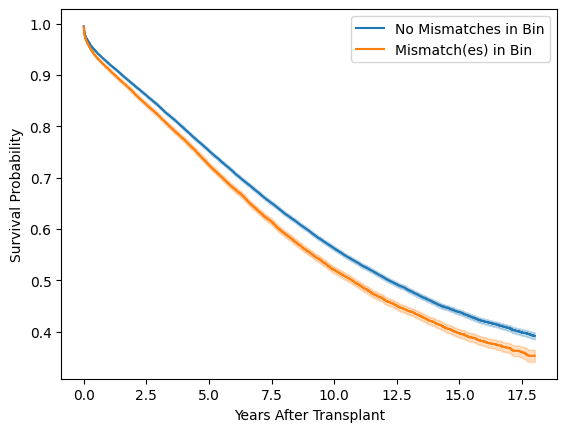

In [13]:
Top_Bin_Summary(cox_test_data, 'grf_fail', 'graftyrs', bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores)